# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



In [1]:
!nvidia-smi

Mon Jul 25 18:27:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        Off  | 00000000:04:00.0  On |                  N/A |
| 51%   52C    P0    45W / 120W |    342MiB /  8123MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1


Next, set up virtual display，and import all necessaary packages.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [3]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  #torch.set_deterministic(True)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [4]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [5]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [6]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [7]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [8]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [9]:
observation, reward, done, info = env.step(random_action)

In [10]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [11]:
print(reward)

-0.8588845024543161


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

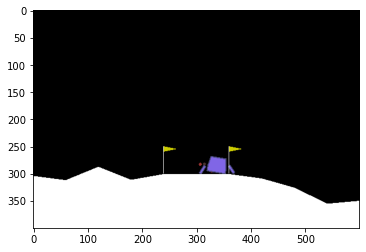

In [12]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

## Actor Critic

In [13]:
from torch.optim.lr_scheduler import StepLR
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh()
        )
        
        self.actor = nn.Linear(16, 4)
        self.critic = nn.Linear(16, 1)
        
        self.values = []
        self.optimizer = optim.SGD(self.parameters(), lr=0.001)
        
    def forward(self, state):
        hid = self.fc(state)
        self.values.append(self.critic(hid).squeeze(-1))
        return F.softmax(self.actor(hid), dim=-1)
    
    def learn(self, log_probs, rewards):
        values = torch.stack(self.values)
        loss = (-log_probs * (rewards - values.detach())).sum() + F.smooth_l1_loss(values, rewards)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.values = []
        
    def sample(self, state):
        action_prob = self(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob
        

Lastly, build a network and agent to start training.

In [14]:
agent = ActorCritic()

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [15]:
agent.train()  # Switch network into training mode 
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 500        # totally update the agent for 400 time
rate = 0.99

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            #rewards.append(reward) # change here
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                # calculate accumulative rewards
                for i in range(2, len(seq_rewards)+1):
                    seq_rewards[-i] += rate * (seq_rewards[-i+1])
                rewards += seq_rewards
                
                break

 
    print(f"rewards looks like ", np.shape(rewards))  
    print(f"log_probs looks like ", len(log_probs))     
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

  0%|          | 0/500 [00:00<?, ?it/s]

rewards looks like  (503,)
log_probs looks like  503
logs prob looks like  torch.Size([503])
torch.from_numpy(rewards) looks like  torch.Size([503])
rewards looks like  (530,)
log_probs looks like  530
logs prob looks like  torch.Size([530])
torch.from_numpy(rewards) looks like  torch.Size([530])
rewards looks like  (468,)
log_probs looks like  468
logs prob looks like  torch.Size([468])
torch.from_numpy(rewards) looks like  torch.Size([468])
rewards looks like  (493,)
log_probs looks like  493
logs prob looks like  torch.Size([493])
torch.from_numpy(rewards) looks like  torch.Size([493])
rewards looks like  (500,)
log_probs looks like  500
logs prob looks like  torch.Size([500])
torch.from_numpy(rewards) looks like  torch.Size([500])
rewards looks like  (451,)
log_probs looks like  451
logs prob looks like  torch.Size([451])
torch.from_numpy(rewards) looks like  torch.Size([451])
rewards looks like  (554,)
log_probs looks like  554
logs prob looks like  torch.Size([554])
torch.from_nu

rewards looks like  (410,)
log_probs looks like  410
logs prob looks like  torch.Size([410])
torch.from_numpy(rewards) looks like  torch.Size([410])
rewards looks like  (389,)
log_probs looks like  389
logs prob looks like  torch.Size([389])
torch.from_numpy(rewards) looks like  torch.Size([389])
rewards looks like  (521,)
log_probs looks like  521
logs prob looks like  torch.Size([521])
torch.from_numpy(rewards) looks like  torch.Size([521])
rewards looks like  (384,)
log_probs looks like  384
logs prob looks like  torch.Size([384])
torch.from_numpy(rewards) looks like  torch.Size([384])
rewards looks like  (486,)
log_probs looks like  486
logs prob looks like  torch.Size([486])
torch.from_numpy(rewards) looks like  torch.Size([486])
rewards looks like  (486,)
log_probs looks like  486
logs prob looks like  torch.Size([486])
torch.from_numpy(rewards) looks like  torch.Size([486])
rewards looks like  (465,)
log_probs looks like  465
logs prob looks like  torch.Size([465])
torch.from_nu

rewards looks like  (396,)
log_probs looks like  396
logs prob looks like  torch.Size([396])
torch.from_numpy(rewards) looks like  torch.Size([396])
rewards looks like  (483,)
log_probs looks like  483
logs prob looks like  torch.Size([483])
torch.from_numpy(rewards) looks like  torch.Size([483])
rewards looks like  (465,)
log_probs looks like  465
logs prob looks like  torch.Size([465])
torch.from_numpy(rewards) looks like  torch.Size([465])
rewards looks like  (343,)
log_probs looks like  343
logs prob looks like  torch.Size([343])
torch.from_numpy(rewards) looks like  torch.Size([343])
rewards looks like  (433,)
log_probs looks like  433
logs prob looks like  torch.Size([433])
torch.from_numpy(rewards) looks like  torch.Size([433])
rewards looks like  (441,)
log_probs looks like  441
logs prob looks like  torch.Size([441])
torch.from_numpy(rewards) looks like  torch.Size([441])
rewards looks like  (523,)
log_probs looks like  523
logs prob looks like  torch.Size([523])
torch.from_nu

rewards looks like  (439,)
log_probs looks like  439
logs prob looks like  torch.Size([439])
torch.from_numpy(rewards) looks like  torch.Size([439])
rewards looks like  (378,)
log_probs looks like  378
logs prob looks like  torch.Size([378])
torch.from_numpy(rewards) looks like  torch.Size([378])
rewards looks like  (428,)
log_probs looks like  428
logs prob looks like  torch.Size([428])
torch.from_numpy(rewards) looks like  torch.Size([428])
rewards looks like  (568,)
log_probs looks like  568
logs prob looks like  torch.Size([568])
torch.from_numpy(rewards) looks like  torch.Size([568])
rewards looks like  (515,)
log_probs looks like  515
logs prob looks like  torch.Size([515])
torch.from_numpy(rewards) looks like  torch.Size([515])
rewards looks like  (657,)
log_probs looks like  657
logs prob looks like  torch.Size([657])
torch.from_numpy(rewards) looks like  torch.Size([657])
rewards looks like  (538,)
log_probs looks like  538
logs prob looks like  torch.Size([538])
torch.from_nu

rewards looks like  (616,)
log_probs looks like  616
logs prob looks like  torch.Size([616])
torch.from_numpy(rewards) looks like  torch.Size([616])
rewards looks like  (631,)
log_probs looks like  631
logs prob looks like  torch.Size([631])
torch.from_numpy(rewards) looks like  torch.Size([631])
rewards looks like  (449,)
log_probs looks like  449
logs prob looks like  torch.Size([449])
torch.from_numpy(rewards) looks like  torch.Size([449])
rewards looks like  (535,)
log_probs looks like  535
logs prob looks like  torch.Size([535])
torch.from_numpy(rewards) looks like  torch.Size([535])
rewards looks like  (496,)
log_probs looks like  496
logs prob looks like  torch.Size([496])
torch.from_numpy(rewards) looks like  torch.Size([496])
rewards looks like  (674,)
log_probs looks like  674
logs prob looks like  torch.Size([674])
torch.from_numpy(rewards) looks like  torch.Size([674])
rewards looks like  (614,)
log_probs looks like  614
logs prob looks like  torch.Size([614])
torch.from_nu

rewards looks like  (642,)
log_probs looks like  642
logs prob looks like  torch.Size([642])
torch.from_numpy(rewards) looks like  torch.Size([642])
rewards looks like  (762,)
log_probs looks like  762
logs prob looks like  torch.Size([762])
torch.from_numpy(rewards) looks like  torch.Size([762])
rewards looks like  (766,)
log_probs looks like  766
logs prob looks like  torch.Size([766])
torch.from_numpy(rewards) looks like  torch.Size([766])
rewards looks like  (676,)
log_probs looks like  676
logs prob looks like  torch.Size([676])
torch.from_numpy(rewards) looks like  torch.Size([676])
rewards looks like  (854,)
log_probs looks like  854
logs prob looks like  torch.Size([854])
torch.from_numpy(rewards) looks like  torch.Size([854])
rewards looks like  (740,)
log_probs looks like  740
logs prob looks like  torch.Size([740])
torch.from_numpy(rewards) looks like  torch.Size([740])
rewards looks like  (720,)
log_probs looks like  720
logs prob looks like  torch.Size([720])
torch.from_nu

rewards looks like  (870,)
log_probs looks like  870
logs prob looks like  torch.Size([870])
torch.from_numpy(rewards) looks like  torch.Size([870])
rewards looks like  (769,)
log_probs looks like  769
logs prob looks like  torch.Size([769])
torch.from_numpy(rewards) looks like  torch.Size([769])
rewards looks like  (1756,)
log_probs looks like  1756
logs prob looks like  torch.Size([1756])
torch.from_numpy(rewards) looks like  torch.Size([1756])
rewards looks like  (822,)
log_probs looks like  822
logs prob looks like  torch.Size([822])
torch.from_numpy(rewards) looks like  torch.Size([822])
rewards looks like  (881,)
log_probs looks like  881
logs prob looks like  torch.Size([881])
torch.from_numpy(rewards) looks like  torch.Size([881])
rewards looks like  (844,)
log_probs looks like  844
logs prob looks like  torch.Size([844])
torch.from_numpy(rewards) looks like  torch.Size([844])
rewards looks like  (2948,)
log_probs looks like  2948
logs prob looks like  torch.Size([2948])
torch.

logs prob looks like  torch.Size([4120])
torch.from_numpy(rewards) looks like  torch.Size([4120])
rewards looks like  (671,)
log_probs looks like  671
logs prob looks like  torch.Size([671])
torch.from_numpy(rewards) looks like  torch.Size([671])
rewards looks like  (1483,)
log_probs looks like  1483
logs prob looks like  torch.Size([1483])
torch.from_numpy(rewards) looks like  torch.Size([1483])
rewards looks like  (592,)
log_probs looks like  592
logs prob looks like  torch.Size([592])
torch.from_numpy(rewards) looks like  torch.Size([592])
rewards looks like  (1544,)
log_probs looks like  1544
logs prob looks like  torch.Size([1544])
torch.from_numpy(rewards) looks like  torch.Size([1544])
rewards looks like  (734,)
log_probs looks like  734
logs prob looks like  torch.Size([734])
torch.from_numpy(rewards) looks like  torch.Size([734])
rewards looks like  (1658,)
log_probs looks like  1658
logs prob looks like  torch.Size([1658])
torch.from_numpy(rewards) looks like  torch.Size([165

logs prob looks like  torch.Size([3298])
torch.from_numpy(rewards) looks like  torch.Size([3298])
rewards looks like  (654,)
log_probs looks like  654
logs prob looks like  torch.Size([654])
torch.from_numpy(rewards) looks like  torch.Size([654])
rewards looks like  (3307,)
log_probs looks like  3307
logs prob looks like  torch.Size([3307])
torch.from_numpy(rewards) looks like  torch.Size([3307])
rewards looks like  (3322,)
log_probs looks like  3322
logs prob looks like  torch.Size([3322])
torch.from_numpy(rewards) looks like  torch.Size([3322])
rewards looks like  (827,)
log_probs looks like  827
logs prob looks like  torch.Size([827])
torch.from_numpy(rewards) looks like  torch.Size([827])
rewards looks like  (5000,)
log_probs looks like  5000
logs prob looks like  torch.Size([5000])
torch.from_numpy(rewards) looks like  torch.Size([5000])
rewards looks like  (683,)
log_probs looks like  683
logs prob looks like  torch.Size([683])
torch.from_numpy(rewards) looks like  torch.Size([68

rewards looks like  (1712,)
log_probs looks like  1712
logs prob looks like  torch.Size([1712])
torch.from_numpy(rewards) looks like  torch.Size([1712])
rewards looks like  (2514,)
log_probs looks like  2514
logs prob looks like  torch.Size([2514])
torch.from_numpy(rewards) looks like  torch.Size([2514])
rewards looks like  (1525,)
log_probs looks like  1525
logs prob looks like  torch.Size([1525])
torch.from_numpy(rewards) looks like  torch.Size([1525])
rewards looks like  (1590,)
log_probs looks like  1590
logs prob looks like  torch.Size([1590])
torch.from_numpy(rewards) looks like  torch.Size([1590])
rewards looks like  (1604,)
log_probs looks like  1604
logs prob looks like  torch.Size([1604])
torch.from_numpy(rewards) looks like  torch.Size([1604])
rewards looks like  (2707,)
log_probs looks like  2707
logs prob looks like  torch.Size([2707])
torch.from_numpy(rewards) looks like  torch.Size([2707])
rewards looks like  (4166,)
log_probs looks like  4166
logs prob looks like  torch

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


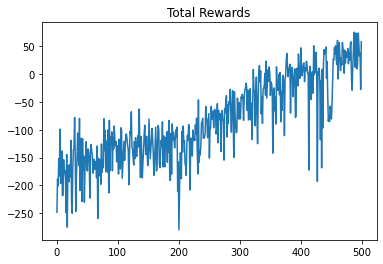

In [16]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


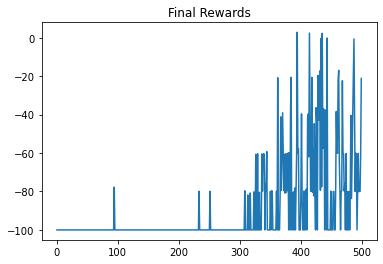

In [17]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

79.99708249155084


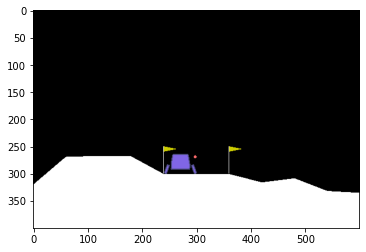

In [18]:
fix(env, seed)
agent.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


In [19]:
print(test_total_reward)
print(np.mean(test_total_reward))

[112.274664456801, 125.20535679793159, 100.8234066635521, 124.31635545490401, 79.99708249155084]
108.52337317294791


Action list

In [20]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 3, 2, 2, 0, 2, 1, 0, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 1, 2, 2, 0, 2, 2, 3, 2, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 3, 2, 3, 0, 3, 2, 2, 2, 2, 3, 3, 2, 2, 1, 3, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 3, 1, 3, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 3, 2, 1, 2, 2, 2, 2, 0, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 3, 2, 0, 3, 2, 3, 3, 2, 2, 2, 3, 0, 2, 2, 3, 3, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 1, 0, 2, 1, 2, 2, 1, 1, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 3, 1, 0, 2, 2, 2, 2, 0, 3, 2, 3, 2, 2, 3, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 3, 1, 1, 2, 0, 3, 1, 0, 3, 3, 3, 3, 3, 0, 0, 1, 3, 0, 0, 3, 0, 3, 1, 3, 0, 1, 1,

Analysis of actions taken by agent

In [21]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{1: 1775, 2: 1011, 0: 1413, 3: 801}


Saving the result of Model Testing


In [22]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

### This is the file you need to submit !!!
Download the testing result to your device



from google.colab import files
files.download(PATH)

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

Your reward is : 112.27
Your reward is : 125.21
Your reward is : 91.03
Your reward is : 124.32
Your reward is : 80.00


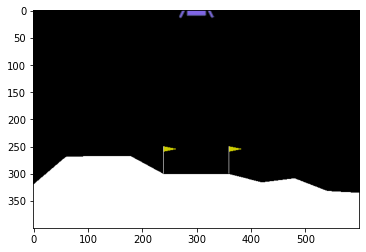

In [23]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

agent.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [24]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 106.57


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
